In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import seaborn as sns

In [3]:
data_dir = os.path.realpath('../../data/transformed_data/')

In [4]:
df_us_air = pd.read_pickle(os.path.join(data_dir, 'USA/df_us_air_small.pkl'))
df_uk_air = pd.read_pickle(os.path.join(data_dir, 'UK/df_uk_air_small.pkl'))
df_ca_air = pd.read_pickle(os.path.join(data_dir, 'Canada/df_ca_air_small.pkl'))

In [5]:
air_units = 'μg/m3'

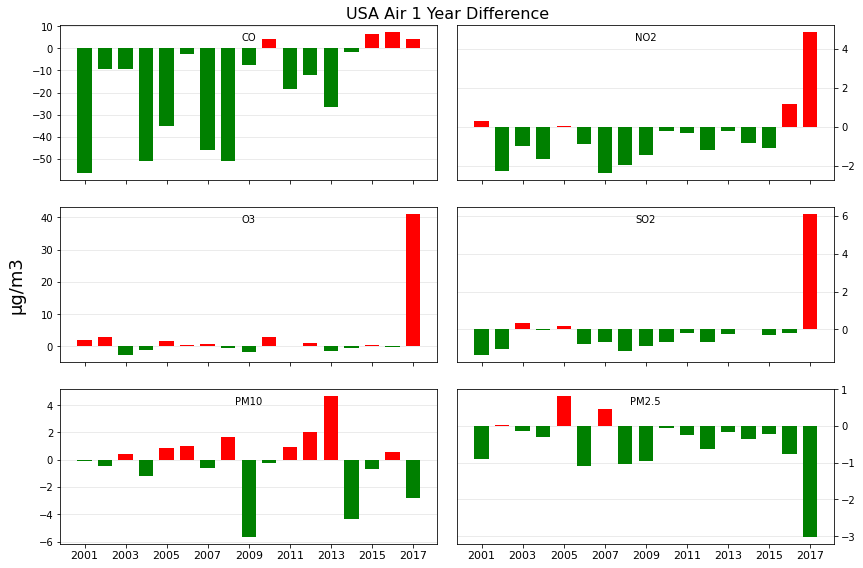

In [6]:
def plot_air_diffed(df, title=''):
    fig, axes = plt.subplots(df.columns.size//2, 2, figsize=(12,8), sharex=True)
    color = plt.cm.Set2
    sign_color = {-1.0:'g', 1.0: 'r'}
    
    for i, ax in enumerate(axes.flatten()):
        signs = np.sign(df[df.columns[i]])
        color_dict = list(map(sign_color.get, signs))
        ax.bar(df.index, df[df.columns[i]], width= 0.7, color=color_dict)
        ax.set(xticks = range(2001, 2018, 2), axisbelow=True)
        if i%2==1:
            ax.yaxis.tick_right()
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params('x', labelsize=11)
        ax.text(.5, .9, df.columns.values[i], horizontalalignment='center', transform=ax.transAxes)
        
    fig.tight_layout(pad=2)

    ax0 = fig.add_subplot(111)
    ax0.set(frame_on=False, xticks=[], yticks=[])
    ax0.set_ylabel(air_units, labelpad=35, fontsize=18)
    ax0.set_title(title, fontsize=16)
    
us_air_1year_diff = (df_us_air - df_us_air.shift(1)).iloc[1:]
plot_air_diffed(us_air_1year_diff, 'USA Air 1 Year Difference')

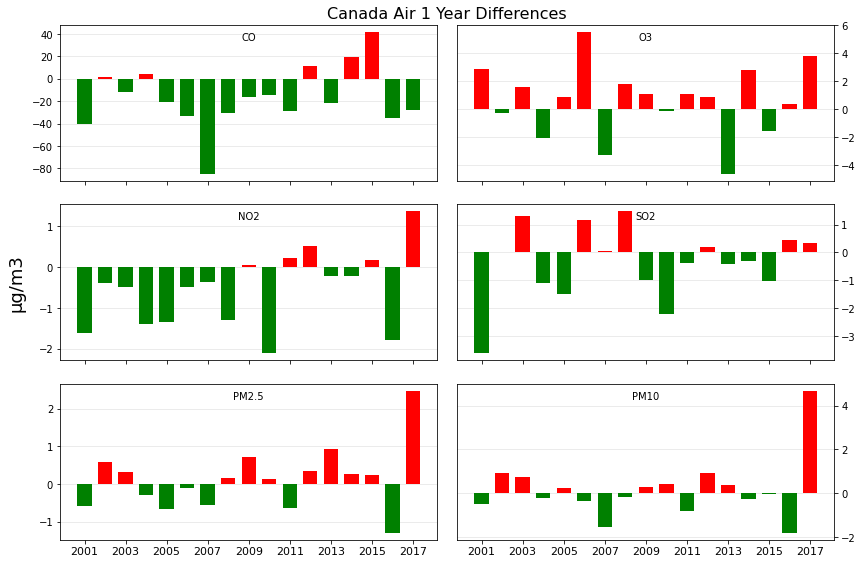

In [7]:
ca_air_1year_diff = (df_ca_air - df_ca_air.shift(1)).iloc[1:]
plot_air_diffed(ca_air_1year_diff, 'Canada Air 1 Year Differences')

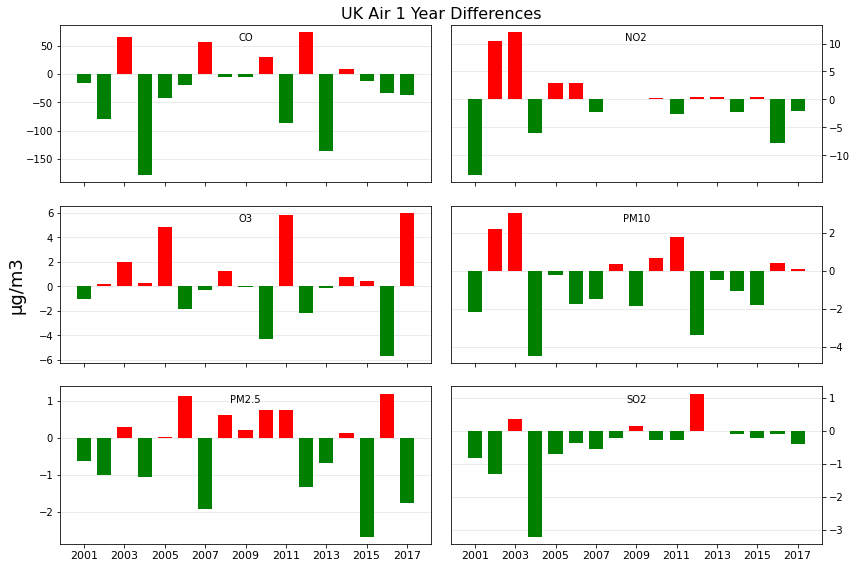

In [8]:
uk_air_1year_diff = (df_uk_air - df_uk_air.shift(1)).iloc[1:]
plot_air_diffed(uk_air_1year_diff, 'UK Air 1 Year Differences')

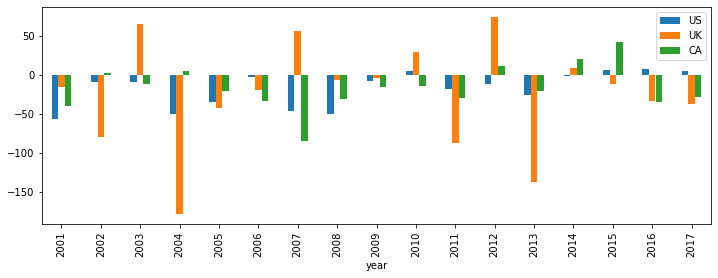

In [9]:
pd.DataFrame({'US': us_air_1year_diff.CO, 'UK': uk_air_1year_diff.CO, 'CA':ca_air_1year_diff.CO}).plot(kind='bar', figsize=(12,4))

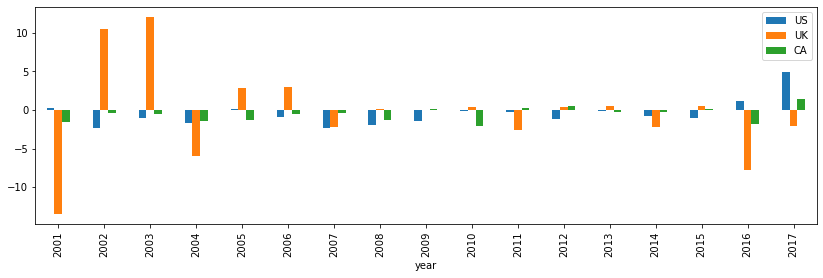

In [10]:
pd.DataFrame({'US': us_air_1year_diff.NO2, 'UK': uk_air_1year_diff.NO2, 'CA':ca_air_1year_diff.NO2}).plot(kind='bar', figsize=(14,4))

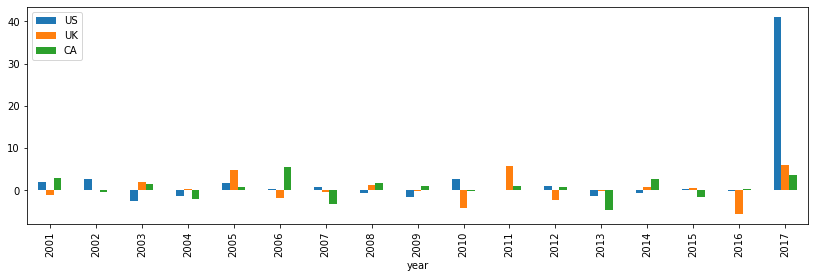

In [11]:
pd.DataFrame({'US': us_air_1year_diff.O3, 'UK': uk_air_1year_diff.O3, 'CA':ca_air_1year_diff.O3}).plot(kind='bar', figsize=(14,4))

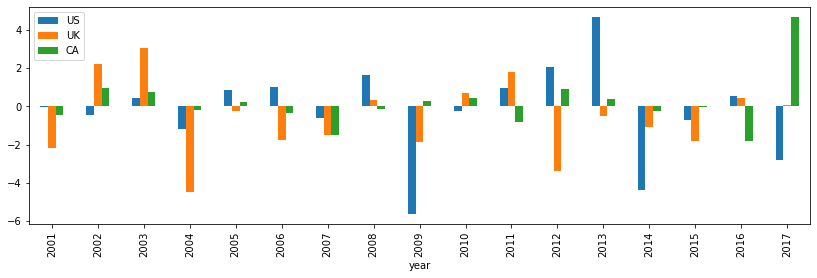

In [12]:
pd.DataFrame({'US': us_air_1year_diff.PM10, 'UK': uk_air_1year_diff.PM10, 'CA':ca_air_1year_diff.PM10}).plot(kind='bar', figsize=(14,4))

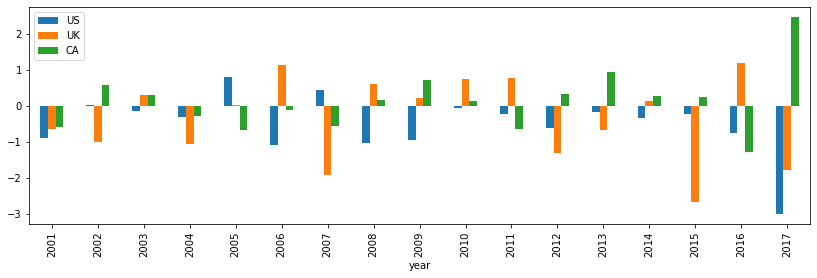

In [13]:
pd.DataFrame({'US': us_air_1year_diff['PM2.5'], 'UK': uk_air_1year_diff['PM2.5'], 'CA':ca_air_1year_diff['PM2.5']}).plot(kind='bar', figsize=(14,4))

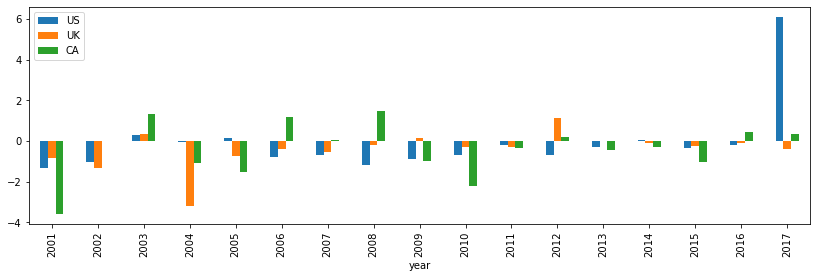

In [14]:
pd.DataFrame({'US': us_air_1year_diff.SO2, 'UK': uk_air_1year_diff.SO2, 'CA':ca_air_1year_diff.SO2}).plot(kind='bar', figsize=(14,4))

In [15]:
cols = ['CO', 'NO2', 'O3', 'SO2', 'PM10', 'PM2.5']

In [16]:
def plot_air_hist():
    fig, axs = plt.subplots(6, 3, figsize = (8,8))
    axs = axs.T
    us_axs = axs[0]; uk_axs = axs[1]; ca_axs = axs[2]
    for i, col in enumerate(cols):
        us_axs[i].hist(df_us_air[col])
        us_axs[i].set(xticks=[], yticks=[], ylabel=col)

        uk_axs[i].hist(df_uk_air[col], color='orange')
        uk_axs[i].set(xticks=[], yticks=[])

        ca_axs[i].hist(df_ca_air[col], color='g')
        ca_axs[i].set(xticks=[], yticks=[])

    us_axs[0].set(title='USA')
    uk_axs[0].set(title='UK')
    ca_axs[0].set(title='Canada');
    
# plot_air_hist()

Since the United States of America and Canada are close, there may be some correlation in the air pollutant concentration level dynamics. The United Kingdom is further away but air pollutants can affect the global air quality and an underlying correlated dynamic might exist with the UK as well.

In [17]:
def crosscorr(series1, series2, lag=0):
        return series1.corr(series2.shift(lag))

def find_air_crosscorr(df1, df2):
    """Find the cross correlation between one series and another with lags up to 16 year lag"""
    dfs_crosscorr = []
    for c in cols:
        dfs_crosscorr.append([crosscorr(df1[c], df2[c], lag) for lag in range(0,17)])
    
    return np.asarray(dfs_crosscorr)

us_uk_crosscorr = find_air_crosscorr(df_us_air, df_uk_air)
us_ca_crosscorr = find_air_crosscorr(df_us_air, df_ca_air)
uk_us_crosscorr = find_air_crosscorr(df_uk_air, df_us_air)
uk_ca_crosscorr = find_air_crosscorr(df_uk_air, df_ca_air)
ca_us_crosscorr = find_air_crosscorr(df_ca_air, df_us_air)
ca_uk_crosscorr = find_air_crosscorr(df_ca_air, df_uk_air)

In [18]:
def plot_cross_corr(ccarr):
    fig, offset_axs = plt.subplots(1, ccarr.shape[0], figsize=(20,4))
    for i, c in enumerate(cols):
        offset = np.ceil(len(ccarr[i])/2)-np.argmax(ccarr[i])
        offset_axs[i].plot(ccarr[i])
        offset_axs[i].axvline(np.ceil(ccarr.shape[1])/2, color='k', linestyle='--', label='Center')
        offset_axs[i].axvline(np.argmax(ccarr[i]), color='r', linestyle='--', label='Peak synchrony')
        offset_axs[i].set_title(f'Offset={offset}, {c}')
    offset_axs[-1].legend(bbox_to_anchor=(1.0, 1.0));

In [19]:
# plot_cross_corr(us_uk_crosscorr)

In [20]:
# plot_cross_corr(us_ca_crosscorr)

In [21]:
# plot_cross_corr(uk_us_crosscorr)

In [22]:
# plot_cross_corr(uk_ca_crosscorr)

In [23]:
# plot_cross_corr(ca_us_crosscorr)

In [24]:
# plot_cross_corr(ca_uk_crosscorr)

In [25]:
pollutant_df_list = [pd.concat({'US':df_us_air[c], 'UK':df_uk_air[c], 'CA':df_ca_air[c]}, axis=1) for c in cols]
df_co, df_no2, df_o3, df_so2, df_pm10, df_pm25  = [*pollutant_df_list]
# [display(df.corr().rename_axis(c, axis=1)) for df, c in zip(pollutant_df_list, cols)]

In the data exploration, we saw that unique air pollutant dynamics over time for each pollutant. Some of these trends are opposing the trends for other pollutants, so can utilize some hypothesis tests to better understand our data.<br>

ANOVA, "Analysis of Variance" tests assume the population distribution is normal, which doesn't look to be the case or is unclear, so we will be using the Levene Test instead.<br><br>
__Levene Test - test for homogeneity of variances. <br>__
$H_0$: Group variances are equal.<br>
$H_1$: Group variances are not homogeneous.

In [156]:
display(pd.concat({c:df.var() for df, c in zip(pollutant_df_list, cols)}, axis=1))
[print(c, '\t', stats.levene(df_us_air[c], df_uk_air[c], df_ca_air[c]).pvalue) for c in cols][0]

,CO,NO2,O3,SO2,PM10,PM2.5
US,11384.166417,25.416792,99.282479,6.691842,3.984656,4.906952
UK,15466.329998,35.460241,7.116437,5.420432,16.117208,2.374806
CA,10949.459695,10.449784,9.098929,3.664158,1.092479,0.650908


CO 	 0.9666125528526742
NO2 	 0.2714404784690186
O3 	 0.7961440041479633
SO2 	 0.16697527037759607
PM10 	 3.1478231144146804e-05
PM2.5 	 0.003169781475603743


We can see that most air pollutant besides Particulate Matter 10 and 2.5 have a large p-value, suggesting that these populations have equal variance, while the small p-values for particulate matter suggest the variance of these populations are not equal.

__Kruskal Wallis test - determines whether the medians of 2 or more groups are different.<br>__
$H_0$: population medians are equal.<br>
$H_1$: population medians are not equal.

In [155]:
# Some pollutants have spikes in concentration in 2017 so we will look at the medians of the groups.
display(pd.concat({c:df.median() for c,df in zip(cols, pollutant_df_list)}, axis=1))
[print(c, '\t', stats.kruskal(df_us_air[c], df_uk_air[c], df_ca_air[c]).pvalue) for c in cols][0]

,CO,NO2,O3,SO2,PM10,PM2.5
US,375.255775,23.438392,51.718908,5.550020,25.444511,10.564356
UK,374.363268,45.840428,43.192308,2.759476,20.934511,13.299047
CA,313.435472,17.693580,36.204132,5.976767,13.781937,5.598325


CO 	 0.1576878162335809
NO2 	 2.1855154301456903e-09
O3 	 1.5471288739218038e-10
SO2 	 0.016374844745843237
PM10 	 2.1855154301456903e-09
PM2.5 	 2.411305239020895e-09


__Shapiro-Wilk Test for Normality__<br>
$H_0$: Data was drawn from a population that is normal distrubtion.<br>
$H_1$: The population is not normally distributed.

In [154]:
print('USA:')
[print(c, '\t', stats.shapiro(df_us_air[c]).pvalue) for c in cols][0]
print('\nUK:')
[print(c, '\t', stats.shapiro(df_uk_air[c]).pvalue) for c in cols][0]
print('\nCanada:')
[print(c, '\t', stats.shapiro(df_ca_air[c]).pvalue) for c in cols][0]

USA:
CO 	 0.020490430295467377
NO2 	 0.14674004912376404
O3 	 9.809824064177519e-08
SO2 	 0.05516941472887993
PM10 	 0.3027000427246094
PM2.5 	 0.11798686534166336

UK:
CO 	 0.227148175239563
NO2 	 0.007895644754171371
O3 	 0.025926563888788223
SO2 	 0.00025348496274091303
PM10 	 0.7562251091003418
PM2.5 	 0.21739302575588226

Canada:
CO 	 0.006115744821727276
NO2 	 0.0665082335472107
O3 	 0.5991191267967224
SO2 	 0.46813127398490906
PM10 	 0.3779781758785248
PM2.5 	 0.1884079873561859


From the Shapiro test, it seems that CO and O3 are normally distributed in the USA, NO2, O3, and SO2 might be normally distributed in the UK, and CO may be normally distributed in Cananda.

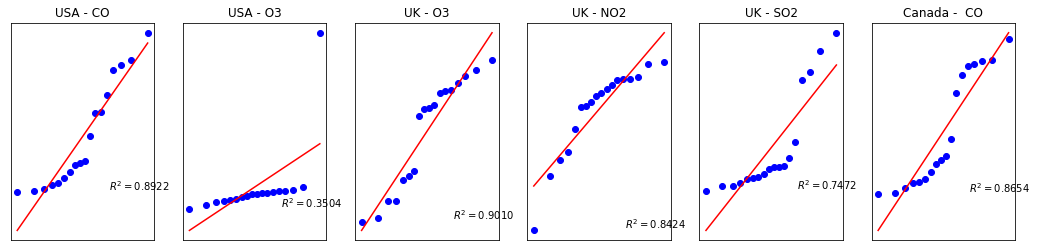

In [29]:
# Visual check for the pollutants in countries that may be normal.
fig, axs = plt.subplots(1,6, figsize=(18,4))

#USA
stats.probplot(df_co.US, plot=axs[0], rvalue=True);
axs[0].set(ylabel='', xlabel='', xticks=[], yticks=[], title='USA - CO')
stats.probplot(df_o3.US.values, plot=axs[1], rvalue=True);
axs[1].set(ylabel='', xlabel='', xticks=[], yticks=[], title='USA - O3')

#UK
stats.probplot(df_o3.UK, plot=axs[2], rvalue=True);
axs[2].set(ylabel='', xlabel='', xticks=[], yticks=[], title='UK - O3')
stats.probplot(df_no2.UK, plot=axs[3], rvalue=True);
axs[3].set(ylabel='', xlabel='', xticks=[], yticks=[], title='UK - NO2')
stats.probplot(df_so2.UK, plot=axs[4], rvalue=True);
axs[4].set(ylabel='', xlabel='', xticks=[], yticks=[], title='UK - SO2')

#Canada
stats.probplot(df_co.CA, plot=axs[5], rvalue=True);
axs[5].set(ylabel='', xlabel='', xticks=[], yticks=[], title='Canada -  CO');

In [30]:
# [df.plot(kind='hist', alpha=0.3) for df in pollutant_df_list];

# Fuel

In [549]:
df_us_fuel = pd.read_pickle(os.path.join(data_dir, 'USA/df_us_fuel.pkl'))
df_uk_fuel = pd.read_pickle(os.path.join(data_dir, 'UK/df_uk_fuel_classInfered.pkl'))
df_ca_fuel = pd.read_pickle(os.path.join(data_dir, 'Canada/df_ca_fuel.pkl'))

In [550]:
# display(df_us_fuel.head(1), df_uk_fuel.head(1), df_ca_fuel.head(1))

In [551]:
display(df_us_fuel.transmission.value_counts(), 
       df_uk_fuel.transmission.value_counts(), 
       df_ca_fuel.transmission.value_counts())

Automatic    14178
Manual        4836
CVT            934
Name: transmission, dtype: int64

Manual       37479
Automatic    24914
CVT           1428
Name: transmission, dtype: int64

Automatic    12517
Manual        4267
CVT            769
Name: transmission, dtype: int64

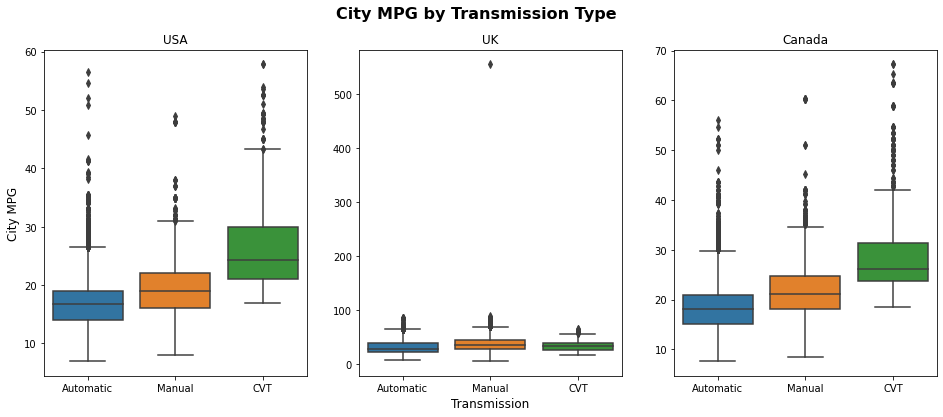

In [552]:
fig, axs = plt.subplots(1,3, figsize=(16,6), sharex=True)
for ax, df, country in zip(axs, [df_us_fuel, df_uk_fuel, df_ca_fuel], ['USA', 'UK', 'Canada']):
    sns.boxplot(x='transmission', y='city_mpg', data = df, order=['Automatic', 'Manual', 'CVT'], ax=ax).set\
                (title=country, ylabel='', xlabel='')
    
axs[0].set_ylabel('City MPG', fontsize=12)
axs[1].set_xlabel('Transmission', fontsize=12)
fig.suptitle('City MPG by Transmission Type', fontweight='bold', fontsize=16);

In [553]:
# the city mpg is a little out the typical range, dropping a '5' to bring it back in line
display(df_uk_fuel[df_uk_fuel.city_mpg == df_uk_fuel.city_mpg.max()])
df_uk_fuel.loc[df_uk_fuel['city_mpg'].argmax(), 'city_mpg'] = 55.4

,year,make,model,transmission,engine_size,fuel_type,city_mpg,highway_mpg,combined_mpg,num_gears,vehicle_class
45908,2014,AUDI,A4 AVANT,Manual,2.0,Diesel,555.4,70.6,64.2,6,STATION WAGON - MID-SIZE


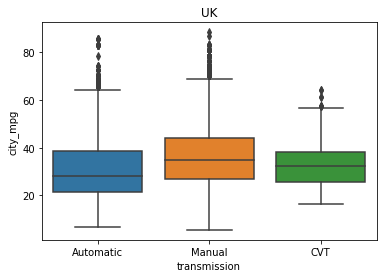

In [554]:
sns.boxplot(x='transmission', y='city_mpg', data = df_uk_fuel, order=['Automatic', 'Manual', 'CVT']).set(title='UK');
# That looks better

In [555]:
mpg_features = ['city_mpg','highway_mpg','combined_mpg']

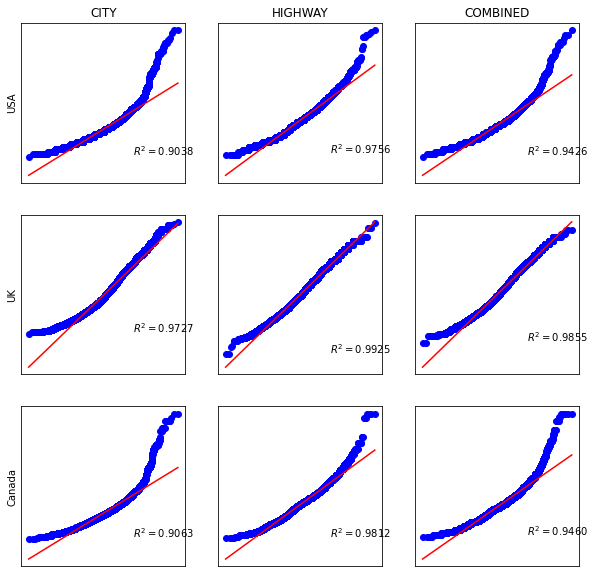

In [556]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
axs = axs.flatten()
#USA
stats.probplot(df_us_fuel.city_mpg, plot=axs[0], rvalue=True);
axs[0].set(ylabel='USA', xlabel='', xticks=[], yticks=[], title='CITY')
stats.probplot(df_us_fuel.highway_mpg, plot=axs[1], rvalue=True);
axs[1].set(ylabel='', xlabel='', xticks=[], yticks=[], title='HIGHWAY')
stats.probplot(df_us_fuel.combined_mpg, plot=axs[2], rvalue=True);
axs[2].set(ylabel='', xlabel='', xticks=[], yticks=[], title='COMBINED')

#UK
stats.probplot(df_uk_fuel.city_mpg, plot=axs[3], rvalue=True);
axs[3].set(ylabel='UK', xlabel='', xticks=[], yticks=[], title='')
stats.probplot(df_uk_fuel.highway_mpg, plot=axs[4], rvalue=True);
axs[4].set(ylabel='', xlabel='', xticks=[], yticks=[], title='')
stats.probplot(df_uk_fuel.combined_mpg, plot=axs[5], rvalue=True);
axs[5].set(ylabel='', xlabel='', xticks=[], yticks=[], title='')

#Canada
stats.probplot(df_ca_fuel.city_mpg, plot=axs[6], rvalue=True);
axs[6].set(ylabel='Canada', xlabel='', xticks=[], yticks=[], title='')
stats.probplot(df_ca_fuel.highway_mpg, plot=axs[7], rvalue=True);
axs[7].set(ylabel='', xlabel='', xticks=[], yticks=[], title='')
stats.probplot(df_ca_fuel.combined_mpg, plot=axs[8], rvalue=True);
axs[8].set(ylabel='', xlabel='', xticks=[], yticks=[], title='');

In [560]:
if ('engine_cat' not in df_us_fuel.columns) & ('small_engine' not in df_us_fuel.columns):
    df_us_fuel['engine_cat'] = pd.cut(df_us_fuel.engine_size, [0.0, 1.0, 2.6, 4.0, 7.0, 9e9],\
                            labels= ['tiny_engine', 'small_engine', 'medium_engine', 'big_engine', 'huge_engine'], right=False)

    df_uk_fuel['engine_cat'] = pd.cut(df_uk_fuel.engine_size, [0.0, 1.0, 2.6, 4.0, 7.0, 9e9], \
                             labels= ['tiny_engine', 'small_engine', 'medium_engine', 'big_engine', 'huge_engine'], right=False)

    df_ca_fuel['engine_cat'] = pd.cut(df_ca_fuel.engine_size, [0.0, 1.0, 2.6, 4.0, 7.0, 9e9], \
                             labels= ['tiny_engine', 'small_engine', 'medium_engine', 'big_engine', 'huge_engine'], right=False)

    df_engine_sizes = pd.concat({'USA': df_us_fuel.engine_cat.value_counts(),\
                                 'UK':df_uk_fuel.engine_cat.value_counts(),\
                                 'Canada':df_ca_fuel.engine_cat.value_counts()},\
                                axis=1)
    display(df_engine_sizes)

    df_us_fuel = pd.concat([df_us_fuel, pd.get_dummies(df_us_fuel.engine_cat)], axis=1).drop('engine_cat', axis=1)
    df_uk_fuel = pd.concat([df_uk_fuel, pd.get_dummies(df_uk_fuel.engine_cat)], axis=1).drop('engine_cat', axis=1)
    df_ca_fuel = pd.concat([df_ca_fuel, pd.get_dummies(df_ca_fuel.engine_cat)], axis=1).drop('engine_cat', axis=1)

In [542]:
print('USA:')
[print(c, '\t', stats.kstest(df_us_fuel[c], 'norm').pvalue) for c in mpg_features][0]
print('\nUK:')
[print(c, '\t', stats.kstest(df_uk_fuel[c], 'norm').pvalue) for c in mpg_features][0]
print('\nCanada:')
[print(c, '\t', stats.kstest(df_ca_fuel[c], 'norm').pvalue) for c in mpg_features][0]

USA:
city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0

UK:
city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0

Canada:
city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0


In [543]:
# Bartlett test for equal variances
[print(c,'\t', stats.bartlett(df_us_fuel[c], df_uk_fuel[c], df_ca_fuel[c]).pvalue) for c in mpg_features][0]

city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0


In [544]:
# Levene test for equal variances
[print(c,'\t', stats.levene(df_us_fuel[c], df_uk_fuel[c], df_ca_fuel[c]).pvalue) for c in mpg_features][0]

city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0


In [545]:
# Fligner-Killeen test for equal variances
[print(c,'\t', stats.fligner(df_us_fuel[c], df_uk_fuel[c], df_ca_fuel[c]).pvalue) for c in mpg_features][0]

city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0


In [546]:
# Kruskal-Wallis test for equal medians
[print(c,'\t', stats.kruskal(df_us_fuel[c], df_uk_fuel[c], df_ca_fuel[c]).pvalue) for c in mpg_features][0]

city_mpg 	 0.0
highway_mpg 	 0.0
combined_mpg 	 0.0


In [547]:
# fig, axs = plt.subplots(1,3, figsize=(16,5))
# for ax, df, country in zip(axs, [df_us_fuel, df_uk_fuel, df_ca_fuel], ['USA', 'UK', 'Canada']):
#     df.make.value_counts()[:20].plot.bar(width= 0.9, color= sns.color_palette('RdYlGn',20), title=country, ax= ax)
# fig.suptitle('Vehicle Count by Manufacturer (Top 20)', fontweight='bold', fontsize=16);

In [563]:
engine_cats = ['tiny_engine', 'small_engine', 'medium_engine', 'big_engine', 'huge_engine']

display('USA', df_us_fuel[np.append(mpg_features, engine_cats)].corr('spearman').loc[engine_cats, mpg_features],
       'UK', df_uk_fuel[np.append(mpg_features, engine_cats)].corr('spearman').loc[engine_cats, mpg_features],
       'CA', df_ca_fuel[np.append(mpg_features, engine_cats)].corr('spearman').loc[engine_cats, mpg_features])

'USA'

,city_mpg,highway_mpg,combined_mpg
tiny_engine,0.029297,0.029055,0.029293
small_engine,0.739893,0.673120,0.725698
medium_engine,-0.045671,-0.017183,-0.039790
big_engine,-0.721537,-0.683091,-0.713316
huge_engine,-0.068797,-0.048716,-0.063244


'UK'

,city_mpg,highway_mpg,combined_mpg
tiny_engine,0.097646,0.096118,0.098075
small_engine,0.460955,0.477786,0.473521
medium_engine,-0.323528,-0.343968,-0.337810
big_engine,-0.359953,-0.358023,-0.360593
huge_engine,-0.026936,-0.026385,-0.026781


'CA'

,city_mpg,highway_mpg,combined_mpg
tiny_engine,0.031025,0.029491,0.030704
small_engine,0.746928,0.677774,0.732793
medium_engine,-0.065429,-0.025366,-0.056617
big_engine,-0.709824,-0.680880,-0.704598
huge_engine,-0.065654,-0.040976,-0.060105


Story seems to be the same regardless of the coefficient, as engine size gets into the medium and larger groups, there is some linearly negative relationship, of varying correlation, to mpg.

In [564]:
df_us_fuel.to_pickle(os.path.join(data_dir, 'USA/us_fuel_engine_cats.pkl'))
df_uk_fuel.to_pickle(os.path.join(data_dir, 'UK/uk_fuel_engine_cats.pkl'))
df_ca_fuel.to_pickle(os.path.join(data_dir, 'Canada/ca_fuel_engine_cats.pkl'))

## Adding flags where pollutant levels are above safe guideline values
### WHO Air quality guideline values
_Guideline values_ <br>
* Fine particulate matter (PM2.5)
        10 μg/m3

* Coarse particulate matter (PM10)
        20 μg/m3
        
* Ozone (O3)
        100 μg/m3
 
* Nitrogen dioxide (NO2)
        40 μg/m3 

* Sulfur dioxide (SO2)
        20 μg/m3      
        
        
##### EPA guidelines for Carbon Monoxide (CO)
* Carbon monoxide (CO)
        9 ppm - Converted = 10310.43 ${\mu g}/{m^3}$
        
        
 _WHO don't provide outdoor CO safetly levels, used EPA.gov guidelines instead._
  <br><br><br>
 _Sources:_

https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health#:~:text=The%20current%20WHO%20guideline%20value,the%20health%20effects%20of%20gaseous.

https://www.epa.gov/criteria-air-pollutants/naaqs-table

In [203]:
for df in [df_us_air, df_uk_air, df_ca_air]:
    df['PM10_unsafe'] = np.where(df.PM10 > 20, 1, 0)
    df['PM25_unsafe'] = np.where(df['PM2.5'] > 10, 1, 0)
    df['NO2_unsafe'] = np.where(df.NO2 > 40, 1, 0)
    df['O3_unsafe'] = np.where(df.O3 > 100, 1, 0)
    df['SO2_unsafe'] = np.where(df.SO2 > 20, 1, 0)
    df['CO_unsafe'] = np.where(df.CO > 10310.43, 1, 0)    